https://assaeunji.github.io/data%20analysis/2021-09-25-arimastock/

https://assaeunji.github.io/statistics/2021-09-08-arimapdq/

https://leedakyeong.tistory.com/entry/Python-%EB%82%A0%EC%94%A8-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0Kaggle%EB%A1%9C-ARIMA-%EC%A0%81%EC%9A%A9%ED%95%98%EA%B8%B0

In [362]:
# 라이브러리 불러오기
from IPython.display import Image

import os
import platform

import warnings
warnings.filterwarnings(action = "ignore")

import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
plt.rcParams["axes.unicode_minus"] = False
%matplotlib inline

if platform.system() == "Windows":
    plt.rcParams["font.family"] = "Malgun Gothic"
else:
    plt.rcParams["font.family"] = "AppleGothic"
    
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima

from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.plot import add_changepoints_to_plot

from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. 데이터 불러오기

In [2]:
# 데이터 불러오기
data = pd.read_csv("./data/AnalysisData.csv", encoding = "CP949").sort_values(by = "발생일시").reset_index(drop = True)

print("Shpae of data :", data.shape, "\n")
display(data.head())
display(data.tail())

Shpae of data : (19815, 16) 



,발생일시,관할해경서,발생해역,발생유형,발생원인,기상,사고선박수,구조인원,부상인원,사망인원,사고위치,위도,경도,선종,톤수,음력
0,2011-01-01 11:00:00,포항,항계내,전복,기상악화,풍랑주의보,1.0,0.0,0.0,0.0,영덕군 노물항내,36.453611,129.435278,어선,4.93,2010-11-27
1,2011-01-01 20:00:00,서귀포,영해,좌초,기상악화,풍랑주의보,3.0,54.0,0.0,0.0,서귀화순 남방 1M,33.208333,126.308333,어선,500.00,2010-11-27
2,2011-01-02 00:38:00,인천,영해-EEZ,기관고장,정비불량,황천5급,1.0,3.0,0.0,0.0,덕적도 서방 55마일 해상,37.316667,124.933333,유조선,186.00,2010-11-28
3,2011-01-02 21:35:00,여수,협수로,좌초,운항부주의,황천5급,1.0,2.0,0.0,0.0,여수 삼산면 대동리 방파제 끝단,34.247778,127.242500,기타,11.00,2010-11-28
4,2011-01-03 10:20:00,서귀포,영해-EEZ,기관고장,정비불량,풍랑주의보,1.0,9.0,0.0,0.0,마라도 남서방 63마일 해상,32.316667,125.450000,어선,75.00,2010-11-29


,발생일시,관할해경서,발생해역,발생유형,발생원인,기상,사고선박수,구조인원,부상인원,사망인원,사고위치,위도,경도,선종,톤수,음력
19810,2020-12-29 13:46:00,포항,영해,작업 중 인명사상,안전부주의,양호,1.0,2.0,0.0,1.0,NaN,36.083056,129.600000,어선,3.0,2020-11-15
19811,2020-12-29 19:45:00,제주,영해,전복,기상악화,풍랑주의보,1.0,0.0,0.0,6.0,NaN,33.546944,126.528056,어선,39.0,2020-11-15
19812,2020-12-29 22:41:00,목포,영해,표류,기상악화,풍랑주의보,1.0,23.0,0.0,0.0,NaN,34.954167,126.078611,예부선,600.0,2020-11-15
19813,2020-12-29 22:41:00,목포,영해,부유물감김,기상악화,풍랑주의보,1.0,4.0,0.0,0.0,NaN,34.954167,126.078611,예부선,124.0,2020-11-15
19814,2020-12-29 23:33:00,부산,영해-EEZ,기관손상,정비불량,풍랑주의보,1.0,8.0,0.0,0.0,NaN,34.777778,129.155278,어선,87.0,2020-11-15


- 해당 데이터를 가지고 통계 기반 모델링과 Prophet 모델을 사용하여 예측을 수행해보도록 하자.

- 우선 예측하기 위해 필요한 변수만을 사용하도록 한다.

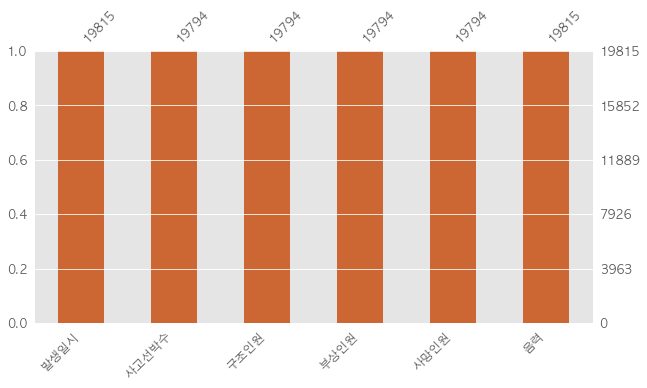

In [3]:
# 데이터 보존을 위해 데이터 복사
model_data = data[["발생일시", "사고선박수", "구조인원", "부상인원", "사망인원", "음력"]].copy()

# 결측치 시각화
msno.bar(model_data, color = (0.8, 0.4, 0.2), fontsize = 12, figsize = (10, 5));

- **사고선박수, 구조인원, 부상인원, 사망인원** 변수에 결측치가 있으므로 삭제해주도록 한다.

- 결측치를 삭제한 후, 발생일시 변수를 사용하여 **Date** 변수를 생성해주도록 한다.

- 구조인원, 부상인원, 사망인원 변수를 사용하여 총 사고인원 변수를 생성해주도록 한다.

In [4]:
print("Shape of model data *Before Delete & Create* :", model_data.shape, "\n")

# 결측치 삭제
model_data = model_data.dropna().reset_index(drop = True)

# 발생일시 변수 사용하여 'Date' 변수 생성
model_data["발생일시"] = pd.to_datetime(model_data["발생일시"])
model_data["Date"] = model_data["발생일시"].dt.date

# 총사고인원 변수 생성
model_data["사고인원"] = (model_data["구조인원"] + model_data["부상인원"] + model_data["사망인원"]).astype("int")

# 사고선박수 변수 정수형으로 변경
model_data["사고선박수"] = model_data["사고선박수"].astype("int")

print("Shape of model data *After Delete & Create* :", model_data.shape, "\n")
display(model_data.head())

Shape of model data *Before Delete & Create* : (19815, 6) 

Shape of model data *After Delete & Create* : (19794, 8) 



,발생일시,사고선박수,구조인원,부상인원,사망인원,음력,Date,사고인원
0,2011-01-01 11:00:00,1,0.0,0.0,0.0,2010-11-27,2011-01-01,0
1,2011-01-01 20:00:00,3,54.0,0.0,0.0,2010-11-27,2011-01-01,54
2,2011-01-02 00:38:00,1,3.0,0.0,0.0,2010-11-28,2011-01-02,3
3,2011-01-02 21:35:00,1,2.0,0.0,0.0,2010-11-28,2011-01-02,2
4,2011-01-03 10:20:00,1,9.0,0.0,0.0,2010-11-29,2011-01-03,9


# 2. 데이터 모델링

- 해당 데이터를 가지고 3가지 관점에서 예측을 수행할 수 있다.

1. 시간에 따른 해상조난사고 건수 예측

2. 시간에 따른 사고선박수 예측

3. 시간에 따른 사고인원 예측

In [299]:
# 데이터 모델링 후, MAE와 RMSE 평가 지표 출력
def scoring(y_true, y_pred):
    
    mae = np.round(mean_absolute_error(y_true, y_pred), 3)
    rmse = np.round(np.sqrt(mean_squared_error(y_true, y_pred)), 3)
    
    df = pd.DataFrame({"MAE" : mae, "RMSE" : rmse}, index = [0])
    
    return df

## 2.1 해상조난사고 건수 예측 모델링

- 해상조난사고 건수를 예측하기 위해서는 일자별로 사고건수 데이터를 만들어줘야 한다.

In [5]:
# 모델에 사용할 데이터 생성
accident_data = pd.pivot_table(data = model_data, index = "Date", values = "사고선박수", aggfunc = "count").rename(columns = {"사고선박수" : "count"})

print("Shape of accident data :", accident_data.shape, "\n")
print("해상조난사고 처음 발생 일자 :", accident_data.index.min(), "\n")
print("해상조난사고 마지막 발생 일자 :", accident_data.index.max(), "\n")
display(accident_data.head())

Shape of accident data : (3485, 1) 

해상조난사고 처음 발생 일자 : 2011-01-01 

해상조난사고 마지막 발생 일자 : 2020-12-29 



,count
Date,
2011-01-01,2
2011-01-02,2
2011-01-03,3
2011-01-04,1
2011-01-05,3


- 해상조난사고는 2011년 01월 01일 부터 2020년 12월 29일까지 발생했음을 알 수 있다.

- 시계열 모델을 사용하여 예측하기 위해서는 해당기간 사이의 날짜가 모두 존재하는지 확인해야 한다.

In [6]:
print("2011년 01월 01일 부터 2020년 12월 29일 까지의 일 수 :", len(pd.date_range(start = "2011-01-01", end = "2020-12-29")))

2011년 01월 01일 부터 2020년 12월 29일 까지의 일 수 : 3651


- 위의 결과를 통해서 현재 데이터는 모든 날짜가 존재하지 않는다는 사실을 알 수 있다.

- 따라서 날짜가 누락된 곳은 개수를 0으로 해서 최종 데이터를 생성해주도록 한다.

In [7]:
# 2011년 01월 01일부터 2020년 12월 29일 날짜가 모두 존재하는 기준 데이터를 생성
criterion_data = pd.DataFrame(index = pd.date_range(start = "2011-01-01", end = "2020-12-29"))

# 두 개의 데이터를 병합하는 과정에서 결측치는 0으로 대체해주도록 한다.
accident_data = pd.merge(criterion_data, accident_data, left_index = True, right_index = True, how = "left").fillna(value = 0)
accident_data["count"] = accident_data["count"].astype("int")

print("Shape of accident data :", accident_data.shape, "\n")
display(accident_data.head())

Shape of accident data : (3651, 1) 



,count
2011-01-01,2
2011-01-02,2
2011-01-03,3
2011-01-04,1
2011-01-05,3


In [361]:
dispa

,count
2011-01-01,2
2011-01-02,2
2011-01-03,3
2011-01-04,1
2011-01-05,3
...,...
2020-12-25,2
2020-12-26,8
2020-12-27,4
2020-12-28,13


### 2.1.1 ARIMA Modeling

- ARIMA 모델이란 Autoregressive Integrated Moving Average 라는 뜻으로, AR 모형과 MV 모형을 합친 모형이다.

- ARIMA 모델은 시계열 데이터의 정상성을 가정하고 있기 때문에 정상성을 확인해주어야 한다는 사실을 잊지 말자.

- 현재 2011년 01월 01일 부터 2020년 12월 29일 까지의 데이터를 생성해주었다.

- ARIMA 모형을 구축한 후, 예측을 수행하기 위해서 학습 데이터와 테스트 데이터를 나눠주도록 한다.

    **학습데이터 : 2011년 ~ 2017년**
    
    **테스트데이터 : 2018년 2019년**

In [88]:
# 학습 데이터
train_data = accident_data[accident_data.index.year < 2018]
print("Shape of train data :", train_data.shape, "\n")

# 테스트 데이터
test_data = accident_data[accident_data.index.year >= 2018]
print("Shape of test data :", test_data.shape)

Shape of train data : (2557, 1) 

Shape of test data : (1094, 1)


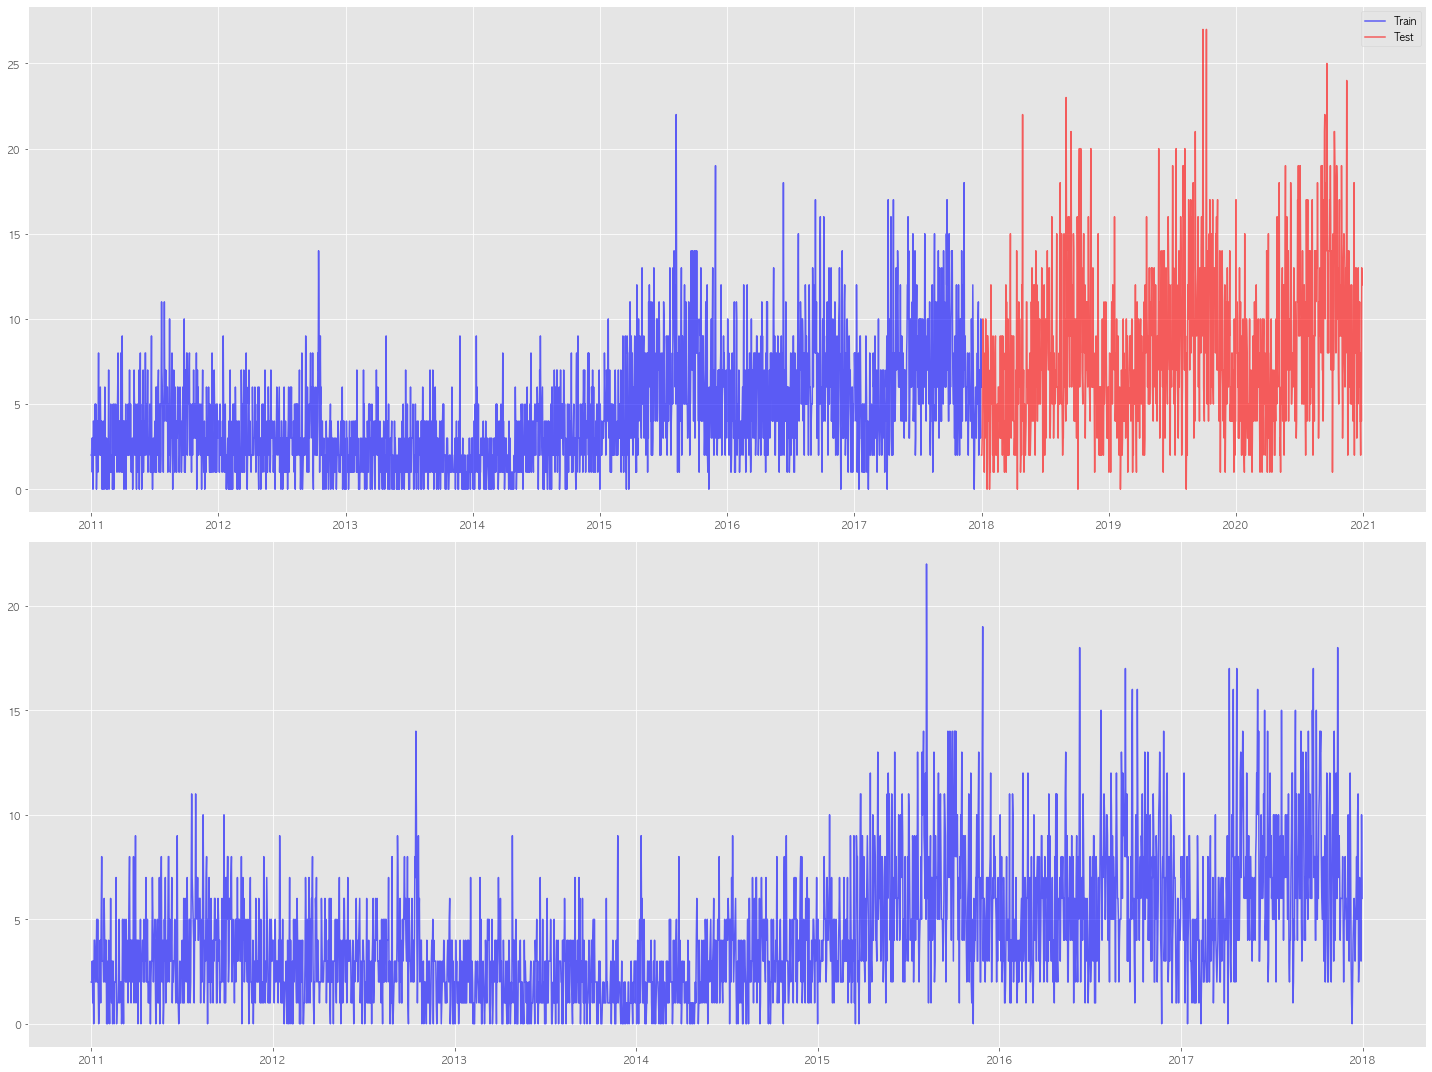

In [186]:
# 시계열 그래프
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 15))

# 학습 데이터와 테스트 데이터를 같이 시각화
axes[0].plot(train_data.index, train_data["count"], color = "blue", alpha = 0.6, label = "Train")
axes[0].plot(test_data.index, test_data["count"], color = "red", alpha = 0.6, label = "Test")
axes[0].legend()

# 학습 데이터 시각화
axes[1].plot(train_data.index, train_data["count"], color = "blue", alpha = 0.6)

fig.tight_layout()

- 2011년 부터 2015년 까지는 사고 추이가 비슷하며, 2015년 이후로 점차 증가하는 추세를 확인할 수 있다.

- 점점 증가하는 추세를 확인할 수 있지만 그래프를 통해서는 정확하게 파악할 수 없으므로, **시계열 분해법**을 통해 좀 더 자세히 살펴보도록 한다.

- **시계열 분해법**이란 시계열 데이터를 추세/순환/계절/불규칙 요소로 분해하는 기법이다.<br><br>

**추세(Trend)**

    데이터가 장기적으로 증가하거나 감소하는 것이며, 추세가 꼭 선형 그래프일 필요는 없다.
    
**순환(Cycle)**

    경기변동과 같이 정치, 경제, 사회적 요인에 의한 변화로, 일정 주기가 없으며 장기적인 변화 현상이다.
    
**계절성(Seasonal)**

    주, 월, 분기, 반기 단위 등 특정 시간의 주기로 나타나는 패턴이다.
    
**불규칙요소(Random, Residual)**

    설명될 수 없는 요인 또는 돌발적인 요인에 의하여 일어나는 변화로, 예측 불가능한 임의의 변동을 의미한다.

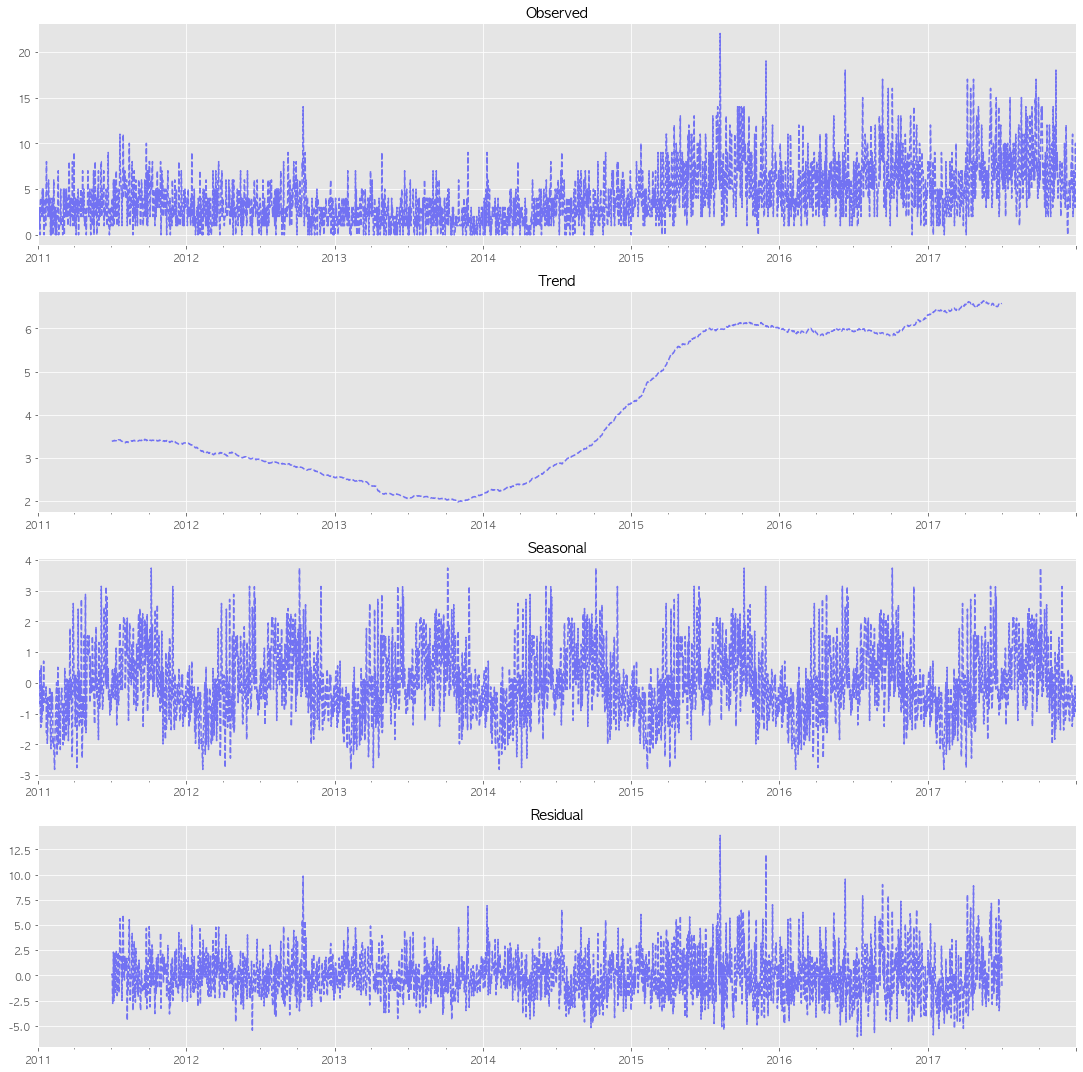

In [91]:
# 시계열 분해법 수행
result = seasonal_decompose(x = train_data["count"], period = 365)

# 시각화를 통해 확인
fig, axes = plt.subplots(nrows = 4, figsize = (15, 15))

# Observed
result.observed.plot(color = "blue", linestyle = "--", alpha = 0.5, ax = axes[0])
axes[0].set_title("Observed")

# Trend
result.trend.plot(color = "blue", linestyle = "--", alpha = 0.5, ax = axes[1])
axes[1].set_title("Trend")

# Seasonal
result.seasonal.plot(color = "blue", linestyle = "--", alpha = 0.5, ax = axes[2])
axes[2].set_title("Seasonal")

# Residual
result.resid.plot(color = "blue", linestyle = "--", alpha = 0.5, ax = axes[3])
axes[3].set_title("Residual")

fig.tight_layout()

- 시계열 분해법을 통해 현재 데이터를 살펴보았을 때, 해상조난사고 건수가 점점 증가하는 추세임을 확인할 수 있다.

- 또한, 일정한 패턴을 나타내기 때문에 정상성을 만족하지 않는다고 볼 수 있다.

- **ACF(자기상관함수)** 그래프를 그려보도록 하자.

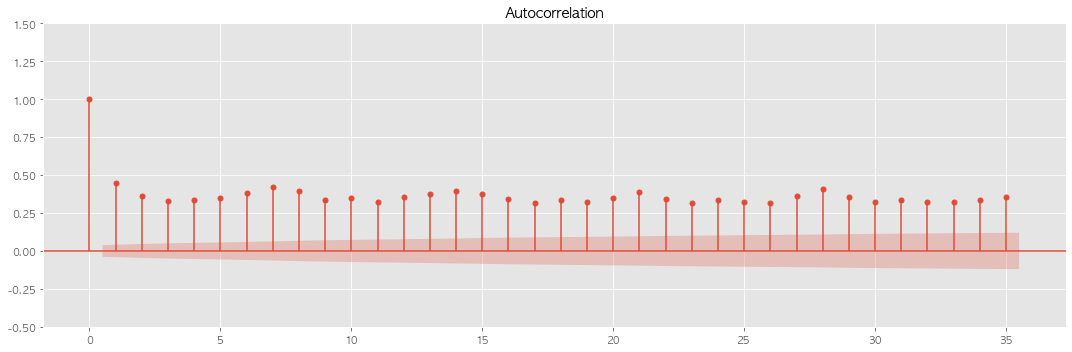

In [92]:
fig, ax = plt.subplots(figsize = (15, 5))

# ACF 그래프
fig = sm.graphics.tsa.plot_acf(train_data, ax = ax)
ax.set_ylim(-0.5, 1.5)

fig.tight_layout()

- 만약 정상시계열 이라면 상대적으로 빠르게 0으로 수렴한다.

- 하지만 위의 그래프는 0으로 수렴하지 않는 것을 볼 수 있으며, 정상성을 만족하지 않는다는 것을 의미한다.

- 이번에는 **ADF 검정(Augmented Dickey-Fuller test)** 으로 정상성을 판단해보도록 한다.

- 해당 검정의 가설을 다음과 같다.

    $H_0(귀무가설) : 자료가 정상성을 만족하지 않는다.$
    
    $H_1(대립가설) : 자료가 정상성을 만족한다.$

In [93]:
# ADF 검정을 수행하기 위한 함수 생성
def print_adfuller(data = None):
    
    # 'adfuller' 함수를 사용하여 ADF 검정 수행
    result = adfuller(data)
    
    print("ADF Statistic : {}".format(result[0]), "\n")
    print("P-Value : {}".format(result[1]), "\n")
    print("Critical Values :")
    
    for key, value in result[4].items():
        print("\t%s : %.3f" %(key, value))

In [94]:
print_adfuller(data = train_data)

ADF Statistic : -2.6963851552769715 

P-Value : 0.07466588663711647 

Critical Values :
	1% : -3.433
	5% : -2.863
	10% : -2.567


- 현재 데이터는 P-Value가 0.05를 넘으므로, 귀무가설을 기각하지 못한다.

- 즉, 정상성을 만족하지 못한다.

- 1차 차분을 수행한 후, 정상성을 만족하는지 확인해보도록 하자.

In [95]:
# 1차 차분 수행
train_diff = train_data - train_data.shift()

# ADF 검정 수행
print_adfuller(data = train_diff[1:])

ADF Statistic : -16.41964654265931 

P-Value : 2.537607109840669e-29 

Critical Values :
	1% : -3.433
	5% : -2.863
	10% : -2.567


- P-Value가 0.05보다 작으므로 귀무가설을 기각한다.

- 즉, **1차 차분한 데이터**는 정상성을 만족한다.

- 정상성을 만족하는 차분된 데이터로 ACF와 PACF 그래프를 그려 ARIMA 모형의 p와 q를 결정하도록 한다.

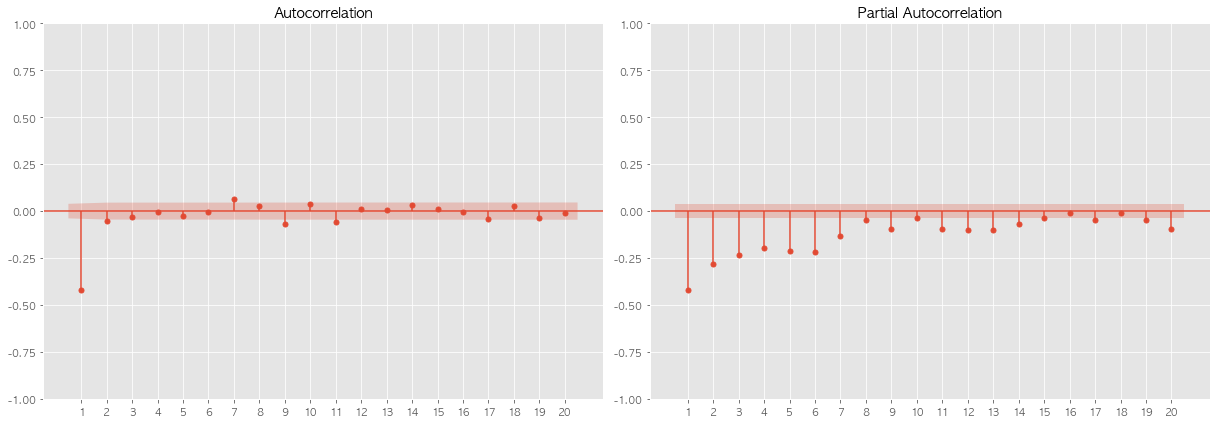

In [96]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 6))

# ACF
fig = sm.graphics.tsa.plot_acf(train_diff[1:], zero = False, lags = 20, ax = axes[0])
axes[0].set_xticks(ticks = range(1, 21))

# PACF
fig = sm.graphics.tsa.plot_pacf(train_diff[1:], zero = False, lags = 20, ax = axes[1])
axes[1].set_xticks(ticks = range(1, 21))

fig.tight_layout()

- ACF와 PACF 두 그래프 점차 감소하여 0에 접근함을 확인할 수 있다.

- 하지만 ARIMA의 정확한 $p, q$ 차수를 판단하기 힘들다.

- 따라서 `pmdarima` 라이브러리의 `auto_arima`를 사용하도록 하자.

- 위에서 1차 차분을 수행했을 때 정상성을 만족했으므로 `d` 인자의 값으로 1을 넣어주도록 한다.

In [98]:
# ARIMA 모형 적합
train_model = auto_arima(y = train_data, d = 1, seasonal = True, stepwise = True, trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12068.783, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13412.682, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12913.889, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12102.647, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13410.683, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12066.073, Time=0.86 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=12064.117, Time=0.40 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=12066.042, Time=1.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12064.836, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12066.523, Time=2.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=12062.398, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=12100.847, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=12064.357, Time=0.34 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=12064.328, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0

- auto_arima 함수를 적용한 결과 최적의 모델은 $ARIMA(0, 1, 2)$ 모형으로 나온 것을 확인할 수 있다.

- 이제 최적 모형의 잔차 검정을 수행하도록 한다.

- `summary` 메소드에서 Ljung-Box (Q) / Heteroskedasticity (H) / Jarque-Bera (JB) 검정 만족 여부를 파악할 수 있다.

In [99]:
display(train_model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2557
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -6028.199
Date:                Wed, 23 Feb 2022   AIC                          12062.398
Time:                        15:36:04   BIC                          12079.936
Sample:                             0   HQIC                         12068.758
                               - 2557                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8267      0.017    -48.990      0.000      -0.860      -0.794
ma.L2         -0.1254      0.017     -7.436      0.000      -0.158      -0.092
sigma2         6.5413      0.141     46.488      0.000       6.266       6.817
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               438.16
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- **Ljung-Box(L1)(Q)** 는 잔차가 백색잡음인지 검정한 통계량이다.

    $H_0$ : 잔차(residual)가 백색잡음(white noise) 시계열을 따른다.
    
    $H_1$ : 잔차(residual)가 백색잡음(white noise) 시계열을 따르지 않는다.

    **Prob(Q)** 값을 보면 0.99 이므로 유의수준 0.05에서 대립가설을 채택할 근거가 없다. 따라서 **시계열 모형이 잘 적합되었고, 남은 잔차는 더 이상 자기상관을 가지지 않는 백색잡음**임을 확인할 수 있다.
    
- **Jarque-Bera (JB)** 는 잔차가 정규성을 띠는지 검정한 통계량이다.

    $H_0$ : 잔차(residual)가 정규성을 만족한다.
    
    $H_1$ : 잔차(residual)가 정규성을 만족하지 않는다.

    **Prob(JB)** 값을 보면 0.00으로 유의수준 0.05에서 대립가설을 채택할 근거가 있다. 따라서 **잔차가 정규성을 따르지 않음**을 확인할 수 있다.
    
- **Heteroskedasticity (H)** 는 잔차의 이분산성을 검정한 통계량이다.

    $H_0$ : 잔차(residual)가 등분산이다.
    
    $H_1$ : 잔차(residual)가 등분산이 아니다.
    
    **Prob(H)** 값을 보면 0.00으로 유의수준 0.05에서 대립가설을 채택할 근거가 있다. 따라서 **잔차가 등분산이 아님**을 확인할 수 있다.

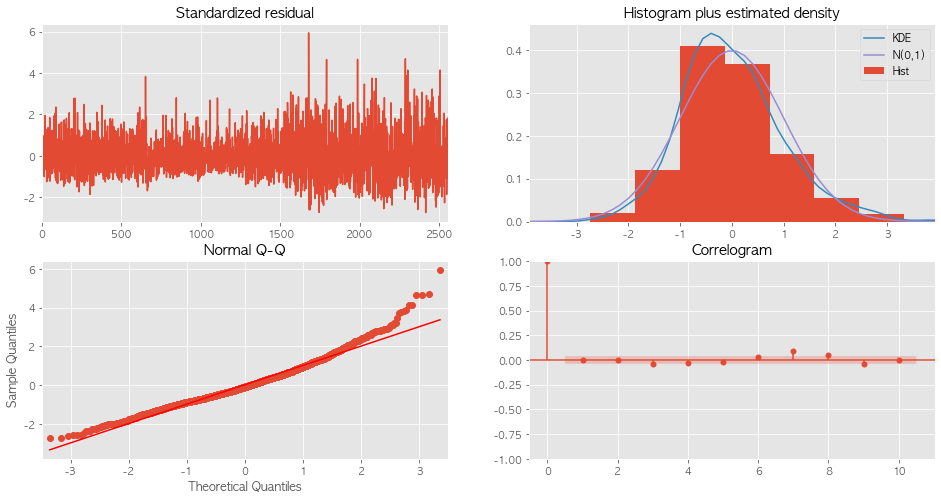

In [101]:
# 시각화를 통해 확인
train_model.plot_diagnostics(figsize = (16, 8))
plt.show()

- 잔차가 백색 잡을을 따르는지 보여주는 그림은 **Standardize residual**과 **Correlogram** 이다.

    **Standardize residual**은 잔차를 시계열로 그린 것이다. 백색잡음의 특성상 시계열이 평균 0을 중심으로 무작위하게 움직이는 것을 볼 수 있다.
    
    **Correlogram**은 잔차에 대한 ACF 이다. ACF도 대부분 허용 범위 안에 위치하여 자기상관이 없음을 확인할 수 있다.
    
- 잔차가 정규성을 만족하는지 보여주는 그림은 **Histogram plus estimated density**와 **Normal Q-Q** 이다.

    **Histogram plus estimated density**는 잔차의 히스토그램을 그려 정규분포 $N(0, 1)$과 밀도를 추정한 그래프를 같이 겹쳐서 보여준다.
    
    **Normal Q-Q** 그래프를 통해 정규성을 만족한다면 점들이 일직선 위에 분포해야 한다. 그러나, 오른쪽 끝에서 약간 벗어나는 것을 확인할 수 있다.
    
- **결과적으로 종합하자면, 현재 적합한 $ARIMA(0, 1, 2)$ 모형은 백색잡음을 나타내지만 정규성은 따르지 않는다고 볼 수 있다.**

- 정규성과 등분산성을 만족하지 않지만 예측을 수행해보도록 한다.

In [172]:
arima = ARIMA(train_data, order = (0, 1, 2))
arima_fit = arima.fit()

In [170]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  count   No. Observations:                 2557
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -6028.199
Date:                Wed, 23 Feb 2022   AIC                          12062.398
Time:                        16:39:26   BIC                          12079.936
Sample:                    01-01-2011   HQIC                         12068.758
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8267      0.017    -48.990      0.000      -0.860      -0.794
ma.L2         -0.1254      0.017     -7.436      0.000      -0.158      -0.092
sigma2         6.5413      0.141     46.488      0.000       6.266       6.817
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               438.16
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [165]:
forecast = arima_fit.predict(start = min(test_data.index), end = max(test_data.index), dynamic = True, type = "levels")

In [168]:
forecast

2018-01-01    5.816088
2018-01-02    5.876974
2018-01-03    5.876974
2018-01-04    5.876974
2018-01-05    5.876974
                ...   
2020-12-25    5.876974
2020-12-26    5.876974
2020-12-27    5.876974
2020-12-28    5.876974
2020-12-29    5.876974
Freq: D, Name: predicted_mean, Length: 1094, dtype: float64

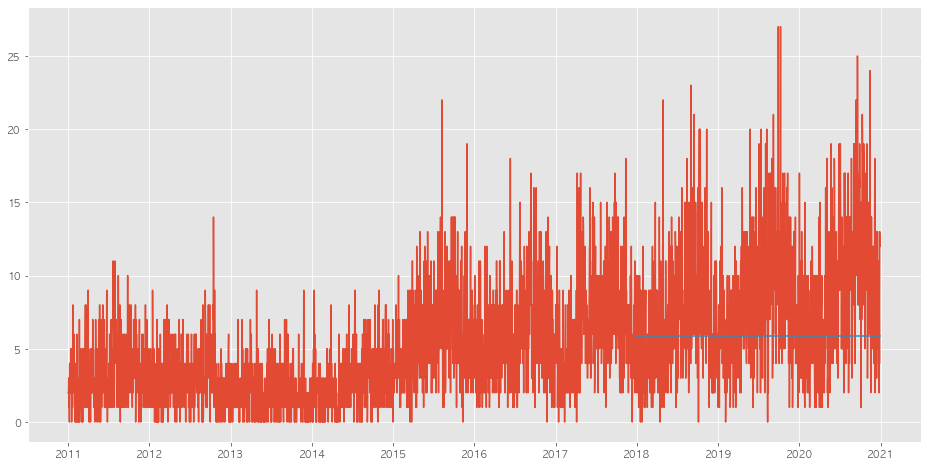

In [167]:
plt.figure(figsize = (16, 8))
plt.plot(accident_data)
plt.plot(forecast)

plt.show()

In [156]:
ARIMA(train_data, order = (0, 1, 2))

In [120]:
def forecast_one_step():
    
    fc, conf_int = train_model.predict(n_periods = 1, return_conf_int=True) # 신뢰구간 출력
    
    return (fc.tolist()[0], np.asarray(conf_int).tolist()[0])

In [121]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in test_data["count"]:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    train_model.update(new_ob)

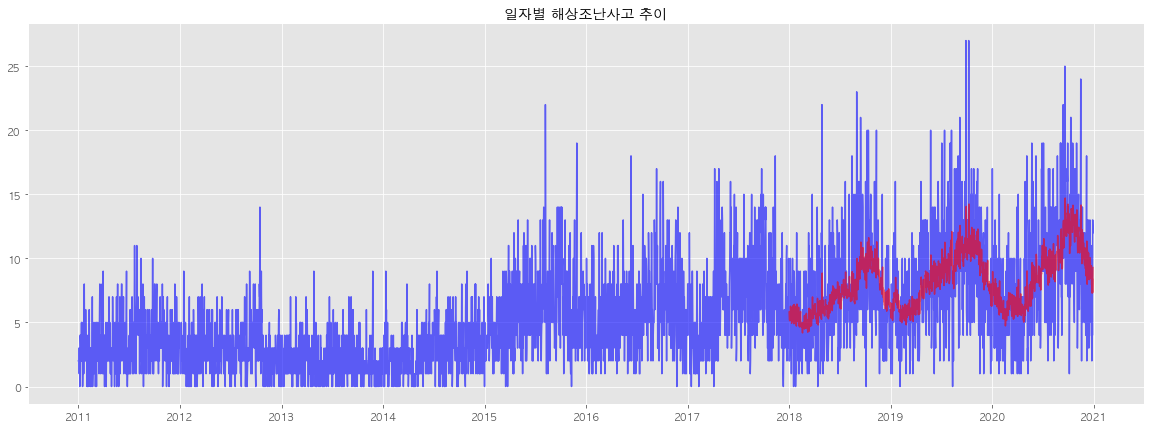

In [133]:
# 시계열 그래프
plt.figure(figsize = (20, 7))

# 학습 데이터
plt.plot(accident_data.index, accident_data["count"], color = "blue", alpha = 0.6, label = "Train data")

# 테스트 데이터
plt.plot(kk.index, kk[0], color = "red", alpha = 0.6, label = "Test data")

plt.title("일자별 해상조난사고 추이", fontsize = 14)
plt.show()

---

### 2.1.2 Prophet Modeling

- Prophet 라이브러리는 일변량 시계열 데이터셋(Univariate Time Series Datasets)을 예측하기 위해 설계된 오픈소스 라이브러리이다.

- additive time series forecasting model을 참고해 구현되었으며, 경향성(Trends), 계절성(Seasonality), 휴일(Holiday) 을 지원하는 모델이다.

- 기본적으로 추세나 계절적 구조를 가진 데이터에 대해 모델데 적합한 Hyperparameters를 자동으로 찾을 수 있도록 설계되어있어 사용하기 쉽다.

- Prophet 모델을 적용하기 전에 학습 데이터와 테스트 데이터를 나눠주도록 하자.

    **학습데이터 : 2011년 ~ 2017년**
    
    **테스트데이터 : 2018년 2019년**
    
- Prophet 모델을 사용하기 위해서는 데이터프레임의 형태를 변경해주어야 한다.

In [207]:
# 데이터프레임 변경
prophet_data = accident_data.reset_index()

# 데이터 컬럼명 변경
prophet_data.columns = ["ds", "y"]

# 학습 데이터
pro_train = prophet_data[prophet_data["ds"].dt.year < 2018]
print("Shape of train data :", pro_train.shape, "\n")

# 테스트 데이터
pro_test = prophet_data[prophet_data["ds"].dt.year >= 2018].reset_index(drop = True)
print("Shape of test data :", pro_test.shape, "\n")

display(pro_train.head())
display(pro_test.head())

Shape of train data : (2557, 2) 

Shape of test data : (1094, 2) 



,ds,y
0,2011-01-01,2
1,2011-01-02,2
2,2011-01-03,3
3,2011-01-04,1
4,2011-01-05,3


,ds,y
0,2018-01-01,2
1,2018-01-02,2
2,2018-01-03,3
3,2018-01-04,7
4,2018-01-05,10


- 위와 같이 데이터를 구성했다면, 파라미터 조정 없이 Prophet 모델을 사용하여 예측을 수행해보도록 하자.

In [296]:
# 실제 데이터 값과 예측한 값을 시각화 해주는 함수 생성
def actual_predict_plot(pred_train = None, pred_test = None):
    
    plt.figure(figsize = (20, 6))
    
    # 실제 학습 데이터와 테스트 데이터 시각화
    plt.scatter(pro_train["ds"], pro_train["y"], label = "Actual Train", color = "black", alpha = 0.2)
    plt.scatter(pro_test["ds"], pro_test["y"], label = "Actual Test", color = "red", alpha = 0.2)
    
    # 예측 학습 데이터와 테스트 데이터 시각화
    plt.scatter(pred_train["ds"], pred_train["yhat"], label = "Predict Train", color = "blue", alpha = 0.5)
    plt.scatter(pred_test["ds"], pred_test["yhat"], label = "Predict Test", color = "green", alpha = 0.5)
    
    plt.title("Acutal & Predict Time Series Plot")
    plt.legend()
    plt.show()

In [303]:
# 예측을 수행한 후, 학습 데이터 테스트 데이터 MAE, RMSE 값을 출력해주는 함수 생성
def prophet_scoring(pred_train = None, pred_test = None):
    
    train_mae = np.round(mean_absolute_error(pro_train["y"], pred_train["yhat"]), 3)
    train_rmse = np.round(np.sqrt(mean_squared_error(pro_train["y"], pred_train["yhat"])), 3)
    
    test_mae = np.round(mean_absolute_error(pro_test["y"], pred_test["yhat"]), 3)
    test_rmse = np.round(np.sqrt(mean_squared_error(pro_test["y"], pred_test["yhat"])), 3)
    
    data = pd.DataFrame({"MAE" : [train_mae, test_mae], "RMSE" : [train_rmse, test_rmse]}, index = ["Train", "Test"])
    
    display(data)

In [337]:
# Prophet 객체 생성 후 학습시키기
base_model = Prophet()
base_model.fit(pro_train)

# 학습 데이터 예측
train_pred = base_model.predict(pro_train)

# 테스트 데이터 예측
test_pred = base_model.predict(pro_test)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -23.3935
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4258.94     0.0013341       61.2328           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121        4260.6   0.000364701       118.273   2.976e-06       0.001      186  LS failed, Hessian reset 
     152       4261.78   0.000295648       95.7891   2.032e-06       0.001      257  LS failed, Hessian reset 
     199       4262.11    0.00672411       99.4803      0.2741           1      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       4262.43   0.000341517       124.027   2.856e-06       0.001      364  LS failed, Hessian reset 
     299       4262.68   5.58204e-06       79.0066       0.964       0.964      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

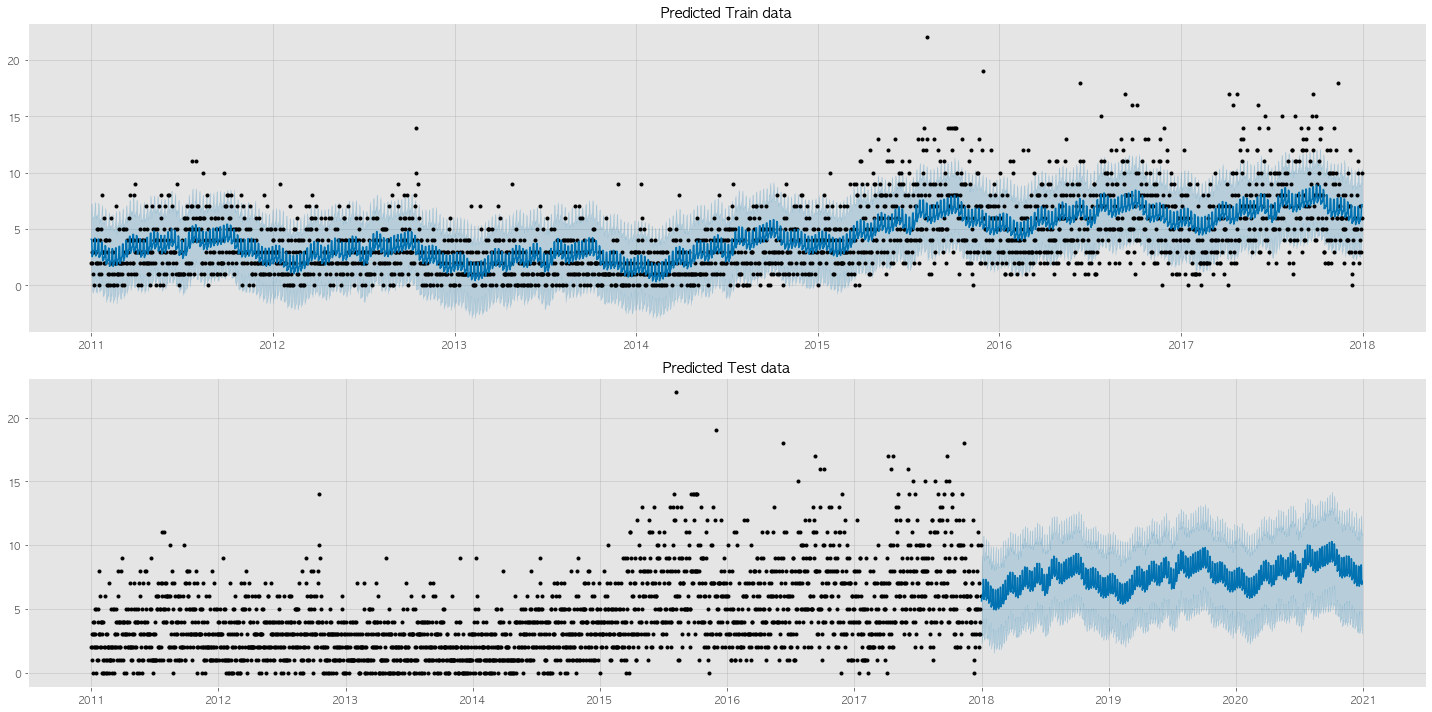

In [328]:
# 예측 결과 시각화
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 10))

# Train data predict
base_model.plot(fcst = train_pred, xlabel = "", ylabel = "", ax = axes[0])
axes[0].set_title("Predicted Train data")

# Test data predict
base_model.plot(fcst = test_pred, xlabel = "", ylabel = "", ax = axes[1])
axes[1].set_title("Predicted Test data")

fig.tight_layout()

- 파란색 선이 모델이 예측한 값을 나타내고, 검정색 값들이 실제 데이터 값을 나타낸다.

- 파라미터를 설정하지 않은 기본 모델이 어느정도 패턴을 잡아냄을 확인할 수 있다.

- 학습 데이터와 테스트 데이터를 같이 확인해보고 평가 지표를 확인해보도록 하자.

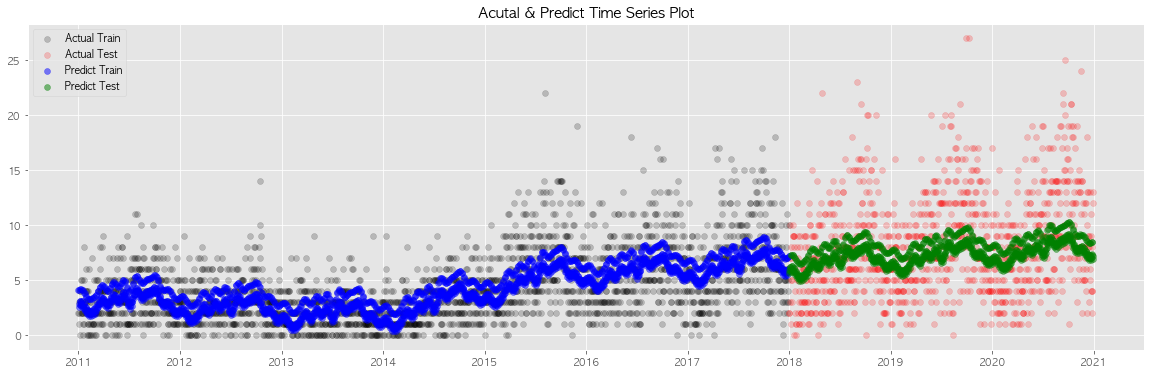

In [329]:
actual_predict_plot(pred_train = train_pred, pred_test = test_pred)

In [330]:
prophet_scoring(pred_train = train_pred, pred_test = test_pred)

,MAE,RMSE
Train,1.932,2.486
Test,3.282,4.172


- 정확하게 값들을 예측하지는 못하지만, 패턴은 잡아내고 있음을 확인할 수 있다.

- 학습 데이터와 테스트 데이터에서의 MAE와 RMSE의 값이 각각 약 2정도 차이남을 확인할 수 있는데 과적합이 되었다고 판단하기는 어렵다.

- Prophet 모델의 파라미터를 변경해보면서 확인해보도록 하자.

- 우선 기본 모델의 각 요소를 확인해보도록 한다.

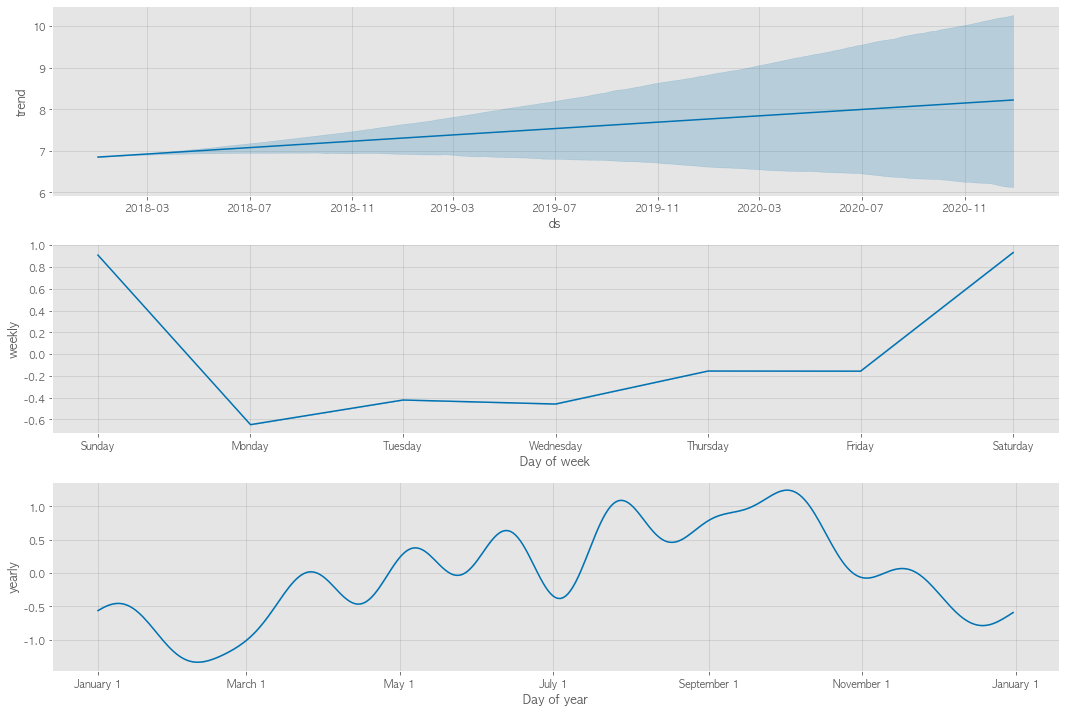

In [331]:
# 모델의 Components 확인
base_model.plot_components(fcst = test_pred, figsize = (15, 10))
plt.show()

- **Trend**를 살펴보면, 증가하는 추세임을 확인할 수 있지만 증가하는 크기가 크게 변하지 않음을 확인할 수 있다.

- **Weekly**는 **주 계절성**을 나타내며, 주말에 사고가 급격하게 증가하고 평일에는 사고가 주말에 비해 적게 일어남을 확인할 수 있다.

- **Yearly**는 **연 계절성**을 나타내며, 3월부터 10월까지는 꾸준히 상승함을 확인할 수 있다.

- 맨 처음으로 Prophet 모델의 **Trend** 파라미터를 조정하며 결과값을 확인해보도록 하자.

- 우선 기본 모델의 changepoint를 시각화해보도록 한다.

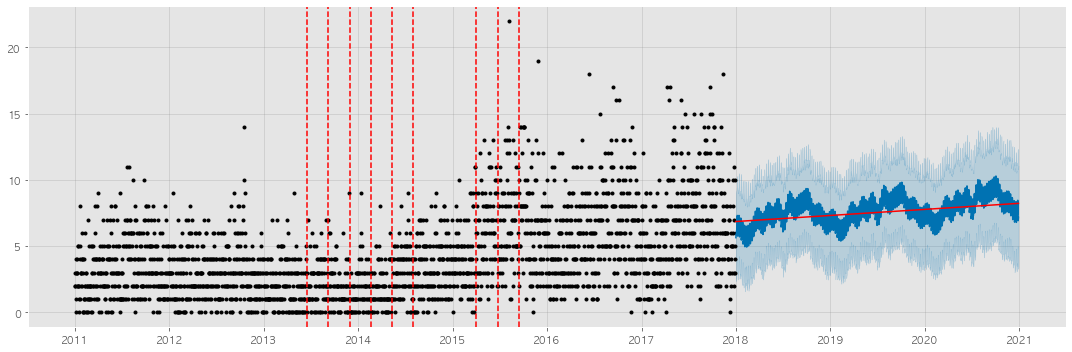

In [320]:
fig = base_model.plot(test_pred, xlabel = "", ylabel = "", figsize = (15, 5))
a = add_changepoints_to_plot(fig.gca(), base_model, test_pred)

- 빨간 실선은 Trend를 의미하며, 빨간 점선은 Trend가 변화하는 changepoint를 의미한다.

- Prophet 모델의 Trend를 변화시킬 수 있는 매개변수는 **changepoint_prior_scale** 이며 기본값은 0.05이다.

- 해당 매개변수에 극단적으로 값을 올려 1을 인자로 주도록 한다.

In [363]:
# Trend를 변경하여 객체 생성 후 학습
trend_model = Prophet(changepoint_prior_scale = 1)
trend_model.fit(pro_train)

# 학습 데이터 예측
train_pred = trend_model.predict(pro_train)

# 테스트 데이터 예측
test_pred = trend_model.predict(pro_test)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -23.3935
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        4309.3     0.0236701        319.22           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4313.16    0.00774326       109.123      0.7122      0.7122      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4316.18    0.00299589       25.8164           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4316.81   0.000275222        15.306      0.1799      0.1799      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4317.38    0.00453536       63.3417       0.339       0.339      580   
    Iter      log prob        ||dx||      ||grad||       alpha  

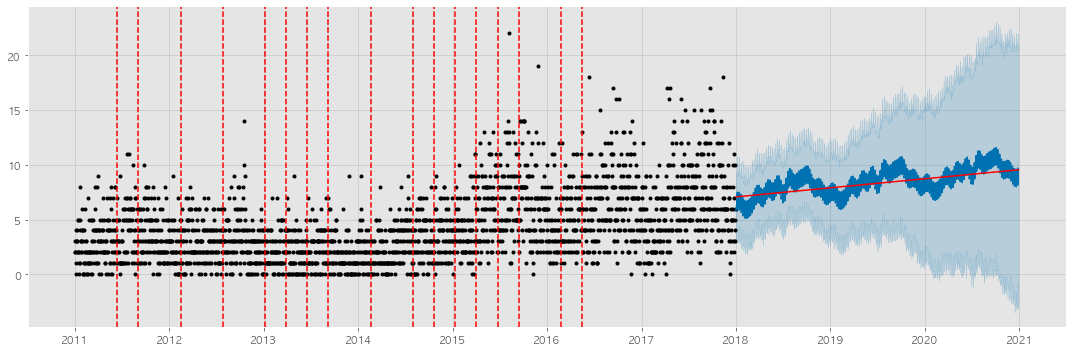

In [364]:
fig = trend_model.plot(test_pred, xlabel = "", ylabel = "", figsize = (15, 5))
a = add_changepoints_to_plot(fig.gca(), trend_model, test_pred)

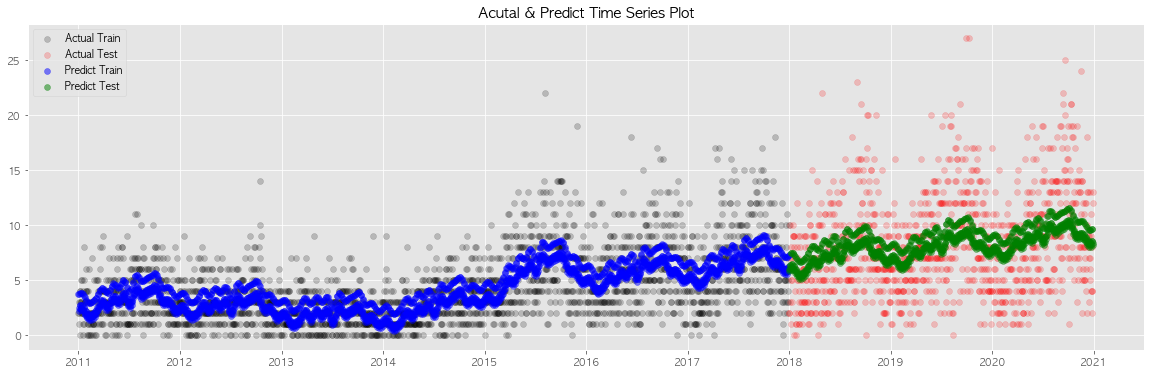

In [365]:
actual_predict_plot(pred_train = train_pred, pred_test = test_pred)

In [366]:
prophet_scoring(pred_train = train_pred, pred_test = test_pred)

,MAE,RMSE
Train,1.910,2.456
Test,3.273,4.074


- changepoint_prior_scale의 값을 크게 했지만 changepoint 개수가 17개로 증가했음을 확인할 수 있다.

- 또한, Trend 파라미터를 조정한 모델의 MAE와 RMSE의 값이 기본 모델과 큰 차이가 없음을 확인할 수 있다.

- 즉, Trend 파라미터 변경을 통해서는 모델의 성능에 큰 차이가 없다는 결론을 내릴 수 있다.

- 다음으로는 Seasonality를 조절할 수 있는 파라미터를 변경해보도록 하자.

In [358]:
# Seasonality를 변경하여 객체 생성 후 학습
season_model = Prophet(yearly_seasonality = True,
                       weekly_seasonality = True,
                       daily_seasonality = True,
                       seasonality_prior_scale = 1000)
season_model.fit(pro_train)

# 학습 데이터 예측
train_pred = season_model.predict(pro_train)

# 테스트 데이터 예측
test_pred = season_model.predict(pro_test)

Initial log joint probability = -23.3935
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4257.99    0.00431859       195.417      0.3081           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4262.33    0.00219217        92.502           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       4262.46   0.000219932       129.597   3.812e-06       0.001      320  LS failed, Hessian reset 
     273       4262.61   0.000125261       94.8958   1.102e-06       0.001      426  LS failed, Hessian reset 
     299       4262.63   2.47893e-06       75.9323      0.6604      0.6604      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       4262.63   4.07701e-06       79.7333   5.209e-08       0.001      507  LS failed, Hessian rese

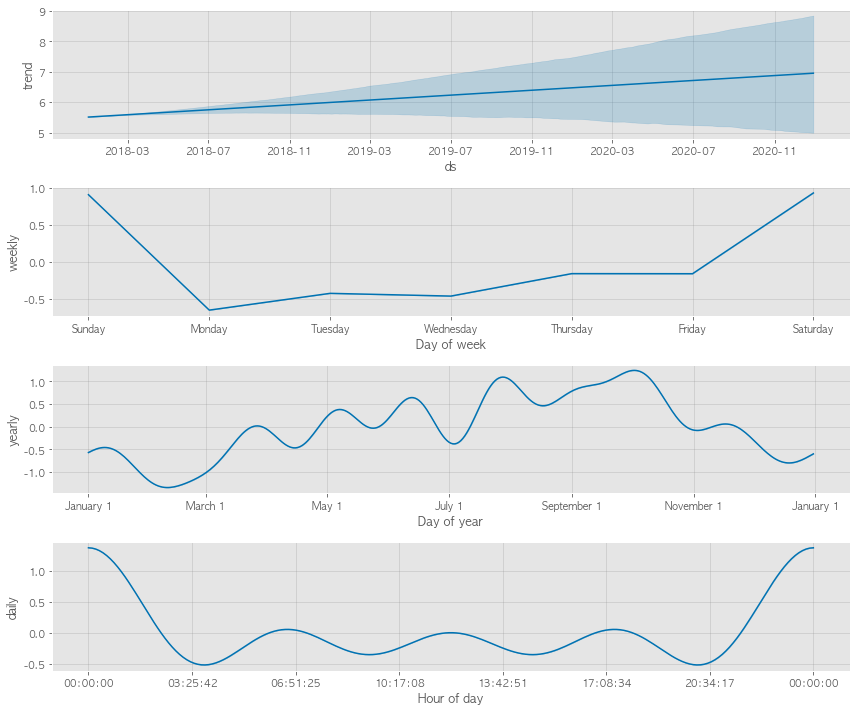

In [359]:
season_model.plot_components(fcst = test_pred, figsize = (12, 10))
plt.show()

In [360]:
prophet_scoring(pred_train = train_pred, pred_test = test_pred)

,MAE,RMSE
Train,1.934,2.488
Test,3.279,4.159


In [ ]:

MAE	RMSE
Train	1.932	2.486
Test	3.282	4.172